**I have used RandomForestRegressor to get RMSE of 0.77 which can be further improved to a better value.I have dropped some attributes with null values and used One hot encoding for categorical data.**

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt

In [2]:
airbnb = pd.read_csv("./airbnb/AB_US_2020.csv")


/var/folders/dv/qnpc2tm905n3c2nrmq03c65w0000gn/T/ipykernel_56148/554524768.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb = pd.read_csv("./airbnb/AB_US_2020.csv")


In [3]:
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [4]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

In [5]:
airbnb.isnull().sum()

id                                     0
name                                  28
host_id                                0
host_name                             33
neighbourhood_group               115845
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        48602
reviews_per_month                  48602
calculated_host_listings_count         0
availability_365                       0
city                                   0
dtype: int64

<AxesSubplot:xlabel='room_type', ylabel='price'>

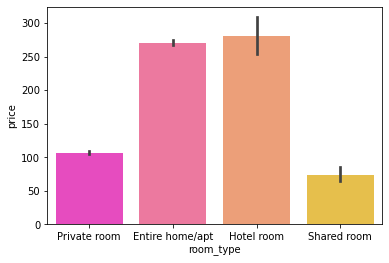

In [6]:
import seaborn as sns
sns.barplot(x='room_type',y='price',data=airbnb,palette='spring')


Here we can see that price depends on the type of room and shared room are of lowest price and hotel room are of highest price.

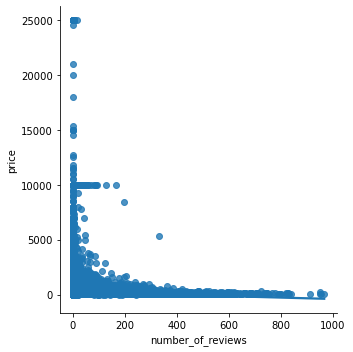

In [7]:
sns.lmplot(x='number_of_reviews',y='price',data=airbnb, palette='spring')


In [8]:
airbnb['neighbourhood_group'].fillna('Others',inplace=True)
airbnb.drop(['name','host_name'],axis=1,inplace=True)
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'],infer_datetime_format=True)
airbnb['reviews_per_month'].fillna(airbnb['reviews_per_month'].mean(),inplace=True)
airbnb["last_review"] = airbnb["last_review"].replace(np.nan, airbnb["last_review"].mode().iloc[0])
airbnb.drop(['id','host_id'],axis=1,inplace=True)


Here we dropped 'name' and 'host_name' as price don't depend on them. And change the format of 'last_review'. And replaced the missing values of 'reviews_per_month' with it's mean value. 

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
airbnb['neighbourhood_group'] = label_encoder.fit_transform(airbnb['neighbourhood_group'])
airbnb['neighbourhood'] = label_encoder.fit_transform(airbnb['neighbourhood'])
airbnb['room_type'] = label_encoder.fit_transform(airbnb['room_type'])
airbnb['city'] = label_encoder.fit_transform(airbnb['city'])

In [22]:
airbnb['room_type'].head()

0    2
1    0
2    0
3    0
4    2
Name: room_type, dtype: int64

Here I have used LabelEncoder for categorical variable. 

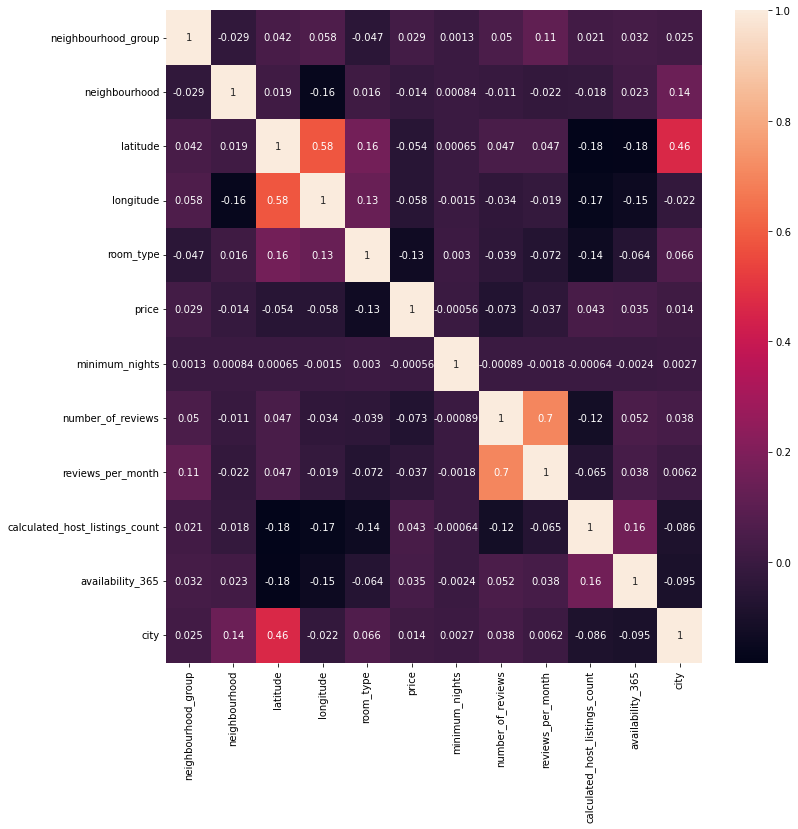

In [12]:
plt.rcParams['figure.figsize']=12,12
g = sns.heatmap(airbnb.corr(),annot=True)



In [13]:
import datetime 
airbnb['last_review'] = airbnb['last_review'].map(datetime.datetime.toordinal)


In [14]:
from scipy import stats
z_scores = stats.zscore(airbnb)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_airbnb = airbnb[filtered_entries]

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaler.fit(new_df)
scaled_features = scaler.fit_transform(new_airbnb)
scaled_features_airbnb = pd.DataFrame(scaled_features, index=new_airbnb.index, columns=new_airbnb.columns)

In [16]:
scaled_features_airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,0.621334,-1.767512,-0.004938,0.775638,1.381058,-0.599407,-0.362783,2.555047,0.143892,-0.148009,-0.395247,-1.143297,-1.88295
1,0.621334,-1.772330,-0.012851,0.778424,-0.686353,1.386301,-0.362783,1.996818,0.701810,-0.245114,0.022237,0.921239,-1.88295
2,0.621334,-1.772330,-0.011537,0.778415,-0.686353,-0.526759,0.812551,1.415331,-0.158313,-0.439324,-0.353498,0.992924,-1.88295
5,0.621334,-1.767512,-0.009789,0.778525,-0.686353,-0.241010,-0.119610,0.601248,0.016036,-0.721810,-0.395247,0.964250,-1.88295
6,0.621334,-1.762694,-0.014965,0.776821,1.381058,-0.657525,-0.362783,2.531787,-0.158313,0.037373,-0.395247,-1.143297,-1.88295


**SPLITTING OF DATA**

In [17]:
from sklearn.model_selection import train_test_split
X = scaled_features_airbnb.drop('price',axis=1)
y = scaled_features_airbnb['price']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state=42)


**RANDOM FOREST REGRESSOR**

In [18]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0)
model=regressor.fit(X_train, y_train)  
y1 = model.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error,r2_score
import math
print('MSE',mean_squared_error(y_test, y1))
print('RMSE',math.sqrt(mean_squared_error(y_test, y1)))
print('Adj R^2 value:',1 - (1-regressor.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

MSE 0.6030891447547098
RMSE 0.7765881435836565
Adj R^2 value: 0.39539775746287953
